---
title: "Pyspark Business Report 2"
subtitle: "A practice example of a pyspark business report using the JOIN method"
author: "Dennis Feyerabend"
date: today                    # or "2025-01-15" or last-modified
date-format: long              # short, medium, long, full, or custom
abstract: "The project demonstrates a full customer-segmentation workflow in PySpark, combining advanced statistical aggregation with relational joins to assemble a consolidated master dataset for downstream business reporting."

# Table of Contents
toc: true                        # Enable table of contents
toc-depth: 4                     # How many heading levels to include (1-6)
toc-title: "Contents"            # Custom TOC title
number-sections: true            # Add numbers to headings
number-depth: 4                  # How deep to number

# Code Display (Global Defaults)
execute:
  echo: true                     # Show code in output
  eval: true                     # Run the code
  warning: false                 # Hide warnings
  error: false                   # Stop on errors (true = continue)
  output: true                   # Show output


format:
  html:
    theme: ../themes/quarto_arrakis-night.scss
    embed-resources: true # Embed resources in HTML
    toc: true
    toc-location: right
    code-fold: true # Hide code blocks by default
---

In [1]:
#| echo: false
#| output: false

import sys
import os
from tkinter.tix import Select

from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, count, when, filter,
    round as spark_round, avg, desc,
    max as spark_max, min as spark_min,
    lit, datediff,
    year, month, dayofweek
)
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

# Apply> Arrakis Night to all plots
from themes import plot_arrakis_night_style
plot_arrakis_night_style.apply()

python_exec = sys.executable

os.environ["PYSPARK_PYTHON"] = python_exec
os.environ["PYSPARK_DRIVER_PYTHON"] = python_exec

spark = SparkSession.builder \
    .appName("Pyspark Join Project") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.pyspark.python", python_exec) \
    .config("spark.pyspark.driver.python", python_exec) \
    .getOrCreate()
spark.sparkContext.setLogLevel("WARN")

DATA_PATH = "../data/ecommerce_5m_v1.csv"

df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

print("=" * 60)
print("   Customer analysis DASHBOARD")
print("=" * 60)

print(f"\nData loaded: {df.count():,} rows (orders)")
print(f"Columns: {df.columns}")

C:\Users\Battlestation\AppData\Local\Temp\ipykernel_33016\1932718342.py:6: DeprecationWarning: The Tix Tk extension is unmaintained, and the tkinter.tix wrapper module is deprecated in favor of tkinter.ttk
  from tkinter.tix import Select


✓ Arrakis Night 'Rivers in the Desert' theme applied
  → Title: Peach | Labels: Gold | Ticks: Gray | Data: Water blues/greens
   Customer analysis DASHBOARD

Data loaded: 5,000,000 rows (orders)
Columns: ['transaction_id', 'customer_id', 'date', 'product_category', 'product_price', 'quantity', 'payment_method', 'country', 'customer_age', 'total']


# Generate customer tables

## Tabelle 1: Customer revenue

In [2]:
#| echo: true
#| output: false

# ============================================================
# TABELLE 1: Customer Value
# ============================================================

print("\n" + "=" * 60)
print("TABELLE 1: Customer Value")
print("=" * 60)

kunden_umsatz = df.groupBy("customer_id").agg(
    count("*").alias("n_orders"),
    spark_round(sum("total"), 2).alias("total_revenue"),
    spark_round(avg("total"), 2).alias("average_order")
)

print(f"\nCustomer numbers: {kunden_umsatz.count():,}")
print("\nTop 10 revenue-high customers:")
kunden_umsatz.orderBy(desc("total_revenue")).show(10)


TABELLE 1: Customer Value

Customer numbers: 489,975

Top 10 revenue-high customers:
+-----------+--------+-------------+-------------+
|customer_id|n_orders|total_revenue|average_order|
+-----------+--------+-------------+-------------+
|      85733|      17|     25860.02|      1521.18|
|     467514|      18|     25849.61|      1436.09|
|     455882|      17|     25711.89|      1512.46|
|      53226|      20|      25558.9|      1277.95|
|     484406|      19|      25450.5|       1339.5|
|      52421|      18|     24621.72|      1367.87|
|     331378|      16|     24455.04|      1528.44|
|     142060|      18|     24410.15|      1356.12|
|      26705|      18|     24174.79|      1343.04|
|      75067|      15|     24134.88|      1608.99|
+-----------+--------+-------------+-------------+
only showing top 10 rows


## Tabelle 2: Customer-Activity

In [3]:
#| echo: true
#| output: false

# ============================================================
# TABELLE 2: Kunden-Aktivitaet (Letzte Bestellung)
# ============================================================

print("\n" + "=" * 60)
print("Table 2: Customer Activity")
print("=" * 60)

kunden_aktivitaet = df.groupBy("customer_id").agg(
    spark_max("date").alias("last_order"),
    spark_min("date").alias("first_order")
)

print("\nExample activity:")
kunden_aktivitaet.show(10)


Table 2: Customer Activity

Example activity:
+-----------+----------+-----------+
|customer_id|last_order|first_order|
+-----------+----------+-----------+
|     482803|2024-11-16| 2023-02-06|
|     105665|2024-10-18| 2023-02-01|
|      97218|2024-10-05| 2023-02-10|
|     478897|2024-12-24| 2023-03-21|
|     192082|2024-12-27| 2023-01-25|
|     158593|2024-12-03| 2023-05-23|
|     307303|2024-09-07| 2023-01-09|
|     460693|2024-09-19| 2023-01-05|
|     102594|2024-10-17| 2023-01-21|
|     375701|2024-11-26| 2023-01-20|
+-----------+----------+-----------+
only showing top 10 rows


## Table 3: Customer-Demography

In [4]:
#| echo: true
#| output: false

# ============================================================
# TABELLE 3: Kunden-Demografie (Land, Alter)
# ============================================================

print("\n" + "=" * 60)
print("Table 3: Costumer Demography")
print("=" * 60)

# Wir nehmen die haeufigsten Werte pro Kunde
# Modus (haeufigster Wert) simulieren mit first()
kunden_demografie = df.groupBy("customer_id").agg(
    spark_round(avg("customer_age"), 0).alias("alter"),
    count(when(col("country") == "Germany", 1)).alias("bestellungen_de"),
    count(when(col("country") == "Austria", 1)).alias("bestellungen_at"),
    count(when(col("country") == "Switzerland", 1)).alias("bestellungen_ch")
)

# DACH-Kunde ja/nein
kunden_demografie = kunden_demografie.withColumn(
    "is_dach_customer",
    when(
        (col("bestellungen_de") > 0) |
        (col("bestellungen_at") > 0) |
        (col("bestellungen_ch") > 0),
        "Ja"
    ).otherwise("Nein")
)

print("\nBeispiel Demografie:")
kunden_demografie.show(10)



Table 3: Costumer Demography

Beispiel Demografie:
+-----------+-----+---------------+---------------+---------------+----------------+
|customer_id|alter|bestellungen_de|bestellungen_at|bestellungen_ch|is_dach_customer|
+-----------+-----+---------------+---------------+---------------+----------------+
|     482803| 50.0|              4|              2|              2|              Ja|
|     105665| 47.0|              3|              4|              0|              Ja|
|      97218| 52.0|              2|              2|              2|              Ja|
|     478897| 49.0|              4|              0|              0|              Ja|
|     192082| 47.0|              6|              2|              2|              Ja|
|     158593| 40.0|              6|              1|              1|              Ja|
|     307303| 43.0|              6|              3|              2|              Ja|
|     460693| 38.0|              3|              2|              3|              Ja|
|     102594|

# Join functions

In [5]:
#| echo: true
#| output: false

# ============================================================
# MASTER-TABELLE: Alle Daten zusammen
# ============================================================

print("\n" + "=" * 60)
print("MASTER JOIN: Alle Tabellen verbinden")
print("=" * 60)

anz_kunden = df.select("customer_id").distinct().count()
print(f'Bevor JOIN: {anz_kunden:,} Kunden')

# Erster JOIN: Umsatz + Aktivitaet
master_step1 = kunden_umsatz.join(
    kunden_aktivitaet, on="customer_id", how="inner"
)

print(f"Nach JOIN 1: {master_step1.count():,} Kunden")

# Zweiter JOIN: + Demografie
kunden_master = master_step1.join(
    kunden_demografie,
    "customer_id",
    "inner"
)

print(f"Nach JOIN 2: {kunden_master.count():,} Kunden")

# Letztes Datum fuer Inaktivitaet berechnen
max_date = df.agg(spark_max("date")).collect()[0][0]
# Berechne inaktivität vom max_date (heute)
kunden_master = kunden_master.withColumn("days_inactive", datediff(lit(max_date), col("last_order")))

print("\nmaster table example:")
kunden_master.show(5)

print("\nColumns in master-table:")
for spalte in kunden_master.columns:
    print(f"  - {spalte}")


MASTER JOIN: Alle Tabellen verbinden
Bevor JOIN: 489,975 Kunden
Nach JOIN 1: 489,975 Kunden
Nach JOIN 2: 489,975 Kunden

master table example:
+-----------+--------+-------------+-------------+----------+-----------+-----+---------------+---------------+---------------+----------------+-------------+
|customer_id|n_orders|total_revenue|average_order|last_order|first_order|alter|bestellungen_de|bestellungen_at|bestellungen_ch|is_dach_customer|days_inactive|
+-----------+--------+-------------+-------------+----------+-----------+-----+---------------+---------------+---------------+----------------+-------------+
|      10013|       8|      5778.63|       722.33|2024-10-12| 2023-04-16| 42.0|              4|              2|              0|              Ja|           79|
|      10022|      11|      3794.03|       344.91|2024-12-20| 2023-01-18| 43.0|              5|              2|              1|              Ja|           10|
|      10032|       8|      2807.79|       350.97|2024-07-16|

## Kunden-Segmente erstellen

In [6]:
#| echo: true
#| output: false

# ============================================================
# KUNDEN-SEGMENTIERUNG
# ============================================================

print("\n" + "=" * 60)
print("KUNDEN-SEGMENTIERUNG")
print("=" * 60)


# Segmente hinzufuegen
kunden_segmentiert = kunden_master \
    .withColumn("inactive", datediff(lit(max_date), col("last_order"))
    ) \
    .withColumn("revenue_segment",
        when(col("total_revenue") >= 5000, "VIP")
        .when(col("total_revenue") >= 1000, "Premium")
        .when(col("total_revenue") >= 200, "Standard")
        .otherwise("Gering")
    ) \
    .withColumn("activity_segment",
        when(col("days_inactive") <= 30, "active")
        .when(col("days_inactive") <= 90, "inactive")
        .otherwise("Verloren")
    ) \
    .withColumn("age_segment",
        when(col("alter") <= 25, "young")
        .when(col("alter") <= 40, "middle")
        .when(col("alter") <= 55, "experienced")
        .otherwise("senior")
    )

print("\nSegmentierte Kunden:")
kunden_segmentiert.select(
    "customer_id",
    "total_revenue",
    "revenue_segment",
    "days_inactive",
    "activity_segment",
    "age_segment",
    "is_dach_customer"
).show(15)


KUNDEN-SEGMENTIERUNG

Segmentierte Kunden:
+-----------+-------------+---------------+-------------+----------------+-----------+----------------+
|customer_id|total_revenue|revenue_segment|days_inactive|activity_segment|age_segment|is_dach_customer|
+-----------+-------------+---------------+-------------+----------------+-----------+----------------+
|      10013|      5778.63|            VIP|           79|        inactive|experienced|              Ja|
|      10022|      3794.03|        Premium|           10|          active|experienced|              Ja|
|      10032|      2807.79|        Premium|          167|        Verloren|     middle|              Ja|
|      10081|      6958.44|            VIP|          164|        Verloren|experienced|              Ja|
|      10090|      1208.29|        Premium|          102|        Verloren|experienced|              Ja|
|      10121|      1479.49|        Premium|          236|        Verloren|     senior|              Ja|
|      10128|      5

# Business Reports

## REPORT 1: Revenue segments

In [7]:
#| echo: true
#| output: true

report_umsatz = kunden_segmentiert.groupBy("revenue_segment").agg(
    count("*").alias("n_customers"),
    spark_round(sum("total_revenue")/1000000, 2).alias("segment_revenue_mill"),
    spark_round(avg("total_revenue"), 2).alias("avg_revenue")
).orderBy(desc("segment_revenue_mill"))

# Generate Umsatz prozent column
window_all = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Percent of customers
report_umsatz = report_umsatz.withColumn(
    "n_customers_percent",
    spark_round(col("n_customers") / sum("n_customers").over(window_all)*100, 2))

report_umsatz = report_umsatz.withColumn(
    "segment_revenue_percent",
    spark_round(col("segment_revenue_mill") / sum("segment_revenue_mill").over(window_all)*100, 2))

# Reorder Spark columns BEFORE toPandas()
report_umsatz_reordered = report_umsatz.select(
    "revenue_segment",
    "n_customers",
    "n_customers_percent",
    "segment_revenue_mill",
    "avg_revenue",
    "segment_revenue_percent"
)

# Convert to table
table_df = (
    report_umsatz_reordered.toPandas()
        .style.hide(axis="index")
        .format({
            "segment_revenue_mill": "{:,.2f}",
            "avg_revenue": "{:,.2f}",
            "segment_revenue_percent": "{:,.2f}",
            "n_customers_percent": "{:,.2f}",
        })
        .set_properties(
            subset=["n_customers", "n_customers_percent", "segment_revenue_mill", "avg_revenue", "segment_revenue_percent"],
            **{"text-align": "right"}
        )
        .set_table_styles([
            {"selector": "td",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]},
            {"selector": "th",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]}
        ])
)

table_df

revenue_segment,n_customers,n_customers_percent,segment_revenue_mill,avg_revenue,segment_revenue_percent
VIP,272201,55.55,"2,141.35","7,866.80",74.89
Premium,211943,43.26,713.82,"3,367.99",24.97
Standard,5633,1.15,4.06,720.32,0.14
Gering,198,0.04,0.02,121.64,0.00


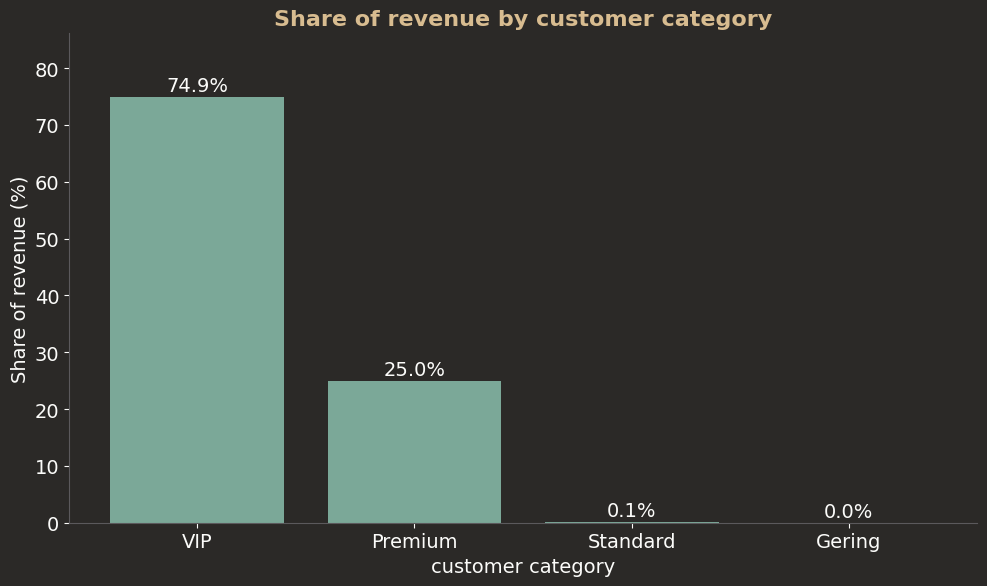

In [8]:
#| echo: false
#| output: true

# 2) Collect small result to Pandas for plotting
pdf = report_umsatz.select(
    "revenue_segment", "segment_revenue_percent"
).toPandas()


fig, ax = plt.subplots(figsize=(10, 6))

# Barplot with automatically assigned colors
ax.bar(
    pdf["revenue_segment"],
    pdf["segment_revenue_percent"]
)

# Labels & formatting
ax.set_title("Share of revenue by customer category", fontsize=16)
ax.set_xlabel("customer category", fontsize=14)
ax.set_ylabel("Share of revenue (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=14)

ax.set_ylim(0, pdf["segment_revenue_percent"].max() * 1.15)

# Rotate x-labels for readability
plt.xticks(rotation=0, fontsize=14)
ax.grid(False)

# Add % labels above bars
for i, v in enumerate(pdf["segment_revenue_percent"]):
    ax.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=14)

plt.tight_layout()
plt.show()

## Report 1: Insights

- VIP customers account for roughly 55% of the total customer base and generate 74.89% of total revenue, making them the strongest revenue driver.
- The remaining customers consist largely of Premium customers (43.26% of the base), contributing an additional 24.97% of revenue.
- Standard and Low-Value customers together contribute only 0.14% of revenue and therefore play a minor economic role

## REPORT 2: Customer activity segments

In [9]:
#| echo: true
#| output: true

report_aktivitaet = kunden_segmentiert.groupBy("activity_segment").agg(
    count("*").alias("n_customers"),
    spark_round(sum("total_revenue")/1000000, 2).alias("segment_revenue_mill")
).orderBy(desc("segment_revenue_mill"))

# Percent of customers
report_aktivitaet = report_aktivitaet.withColumn(
    "segment_activity_percent",
    spark_round(col("segment_revenue_mill") / sum("segment_revenue_mill").over(window_all)*100, 2))

# Convert to table
table_df = (
    report_aktivitaet.toPandas()
        .style.hide(axis="index")
        .format({
            "segment_revenue_mill": "{:,.2f}",
            "segment_activity_percent": "{:,.2f}",
        })
        .set_properties(
            subset=["n_customers", "segment_revenue_mill", "segment_activity_percent"],
            **{"text-align": "right"}
        )
        .set_table_styles([
            {"selector": "td",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]},
            {"selector": "th",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]}
        ])
)

table_df

activity_segment,n_customers,segment_revenue_mill,segment_activity_percent
active,172492,"1,084.97",37.95
inactive,179916,"1,070.26",37.43
Verloren,137567,704.02,24.62


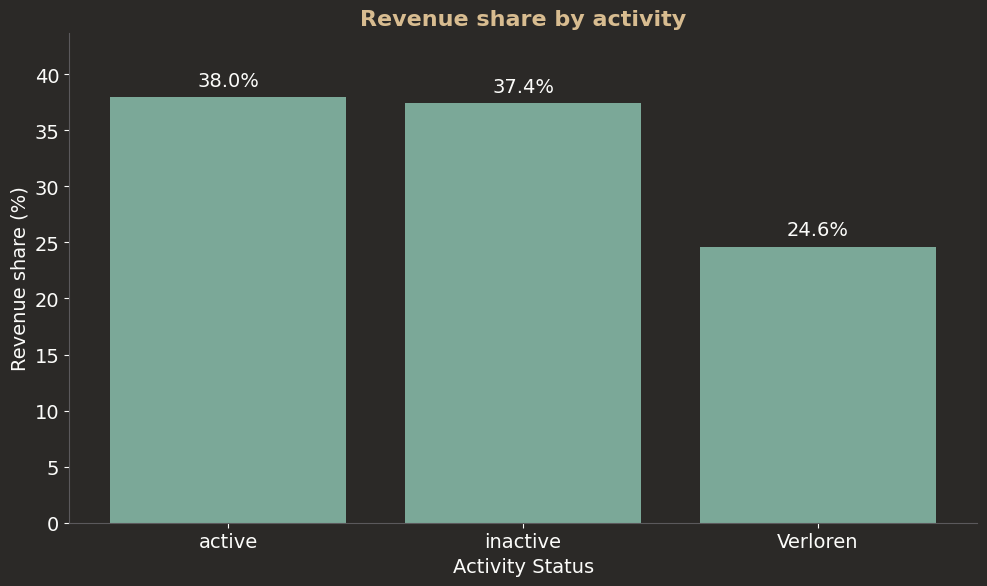

In [10]:
#| echo: true
#| output: true

# 2) Collect small result to Pandas for plotting
pdf = report_aktivitaet.select(
    "activity_segment", "segment_activity_percent"
).toPandas()


fig, ax = plt.subplots(figsize=(10, 6))

# Barplot with automatically assigned colors
ax.bar(
    pdf["activity_segment"],
    pdf["segment_activity_percent"]
)

# Labels & formatting
ax.set_title("Revenue share by activity", fontsize=16)
ax.set_xlabel("Activity Status", fontsize=14)
ax.set_ylabel("Revenue share (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=14)

ax.set_ylim(0, pdf["segment_activity_percent"].max() * 1.15)

# Rotate x-labels for readability
plt.xticks(rotation=0, fontsize=14)
ax.grid(False)

# Add % labels above bars
for i, v in enumerate(pdf["segment_activity_percent"]):
    ax.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=14)

plt.tight_layout()
plt.show()

## Report 2: Insights

- The revenue contribution of active and inactive customers is nearly identical, despite differences in engagement behavior.
- This indicates that inactive customers remain a high-value segment, making them a strategic priority for retention efforts.
- Lost customers are a critical isse as they contributed to 24% of total revenue, making them valuable for retention strategies.

## REPORT 3: Lost VIPs (Critical!)

In [11]:
#| echo: true
#| output: true

verlorene_vips = kunden_segmentiert.filter(
    (col("revenue_segment") == "VIP") &
    (col("activity_segment") == "Verloren")
)

print(f"\nNumber lost VIPs: {verlorene_vips.count():,} ({(verlorene_vips.count() / kunden_segmentiert.filter(col('revenue_segment') == 'VIP').count() * 100):,.2f}% of total VIP customers)")

stats = verlorene_vips.agg(
    spark_round(sum("total_revenue"), 2).alias("verlorener_umsatz"),
    spark_round(avg("total_revenue"), 2).alias("avg_revenue")
).collect()[0]


print(f"Revenue of lost VIPs: {stats['verlorener_umsatz']:,.2f} EUR ({stats['verlorener_umsatz'] / kunden_umsatz.agg(sum('total_revenue')).collect()[0][0] * 100:.2f}% of total revenue)")
print(f"Average per customer: {stats['avg_revenue']:,.2f} EUR")

top10 = (verlorene_vips.select(
    "customer_id",
    "total_revenue",
    "n_orders",
    "last_order",
    "days_inactive"
).orderBy(desc("total_revenue")).limit(10))

# Convert to table
table_df = (
    top10.toPandas()
        .style.hide(axis="index")
        .format({
            "total_revenue": "{:,.2f}",
        })
        .set_properties(
            subset=["customer_id", "total_revenue", "n_orders", "last_order", "days_inactive"],
            **{"text-align": "right"}
        )
        .set_table_styles([
            {"selector": "td",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]},
            {"selector": "th",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]}
        ])
)

print("\nTop 10 lost VIPs:")
table_df


Number lost VIPs: 62,312 (22.89% of total VIP customers)
Revenue of lost VIPs: 470,218,054.34 EUR (16.45% of total revenue)
Average per customer: 7,546.19 EUR

Top 10 lost VIPs:


customer_id,total_revenue,n_orders,last_order,days_inactive
85733,"25,860.02",17,2024-09-28,93
455882,"25,711.89",17,2024-08-11,141
53226,"25,558.90",20,2024-09-04,117
26705,"24,174.79",18,2024-09-22,99
75067,"24,134.88",15,2024-09-30,91
362128,"23,652.76",21,2024-07-22,161
315539,"23,246.34",17,2024-09-10,111
231746,"23,061.97",19,2024-09-21,100
134045,"22,840.01",16,2024-09-01,120
339963,"22,683.69",15,2024-08-30,122


## Report 3: Insights
- Lost VIP customers account for a significant revenue share (16.45% of total turnover)
- The most valuable VIP customers all conducted their last orders around September 2024, suggesting a potential triggering event or change in experience during that period.

## REPORT 4: DACH vs International

In [12]:
#| echo: true
#| output: true

report_dach = kunden_segmentiert.groupBy("is_dach_customer").agg(
    count("*").alias("n_customers"),
    spark_round(sum("total_revenue")/1000000, 2).alias("total_revenue_mill"),
    spark_round(avg("total_revenue"), 2).alias("avg_revenue")
).orderBy(desc("total_revenue_mill"))

report_dach = report_dach.withColumn(
    "total_revenue_percent",
    spark_round(col("total_revenue_mill") / sum("total_revenue_mill").over(window_all)*100, 2)
)

# Convert to table
table_df = (
    report_dach.toPandas()
        .style.hide(axis="index")
        .format({
            "total_revenue_mill": "{:,.2f}", "avg_revenue": "{:,.2f}", "total_revenue_percent": "{:,.2f}"
        })
        .set_properties(
            subset=["is_dach_customer", "n_customers", "total_revenue_mill", "avg_revenue", "total_revenue_percent"],
            **{"text-align": "right"}
        )
        .set_table_styles([
            {"selector": "td",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]},
            {"selector": "th",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]}
        ])
)

table_df

is_dach_customer,n_customers,total_revenue_mill,avg_revenue,total_revenue_percent
Ja,489697,"2,858.74","5,837.78",99.98
Nein,278,0.51,"1,841.44",0.02


## Report 4: Insights
- The DACH region (Germany, Switzerland, Austria) accounts for 99.98% of total revenue, making it by far the dominant market.
- As a result, non-DACH regions contribute only marginally and are not a strategic priority for retention or growth.
- However, this heavy concentration creates a risk: the business is highly dependent on a single geographic region. Any economic downturn, regulatory change, or market shift in DACH would have a disproportionate impact on overall revenue performance.